<a href="https://colab.research.google.com/github/MOEINSOHA/MOEINSOHA/blob/main/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install timm

In [ ]:
import torch
import timm

# Define the same model architecture
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=2)
# Load the state dictionary and map to CPU
model.load_state_dict(torch.load('/content/swin_transformer_model.pth', map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

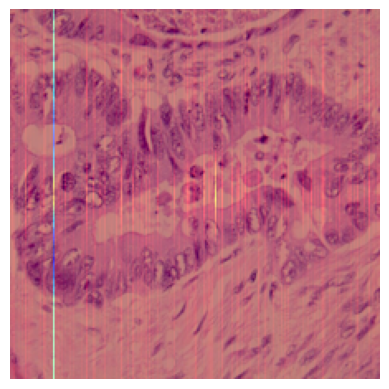

In [8]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import timm

# 1. Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Define the Grad-CAM function
def grad_cam(input_tensor, model, target_layer):
    # Register a hook to get the gradients of the target layer
    gradients = []
    activations = []

    def save_gradient(module, grad_input, grad_output):
        nonlocal gradients
        gradients = [grad_output[0]]  # Save the gradients for later use

    def save_activations(module, input, output):
        nonlocal activations
        activations.append(output)

    # Register hooks
    handle_backward = target_layer.register_full_backward_hook(save_gradient)
    handle_forward = target_layer.register_forward_hook(save_activations)

    # Forward pass
    output = model(input_tensor)

    # Zero gradients
    model.zero_grad()

    # Get the index of the highest scoring class
    class_index = output.argmax(dim=1).item()

    # Backward pass
    output[0, class_index].backward()

    # Remove hooks
    handle_backward.remove()
    handle_forward.remove()

    # Get the gradients and activations
    gradient = gradients[0].cpu().data.numpy()[0]
    activation = activations[0].cpu().data.numpy()[0]

    # Compute the Grad-CAM
    weights = np.mean(gradient, axis=(1, 2))  # Global average pooling
    cam = np.zeros(activation.shape[1:], dtype=np.float32)  # Initialize CAM
    for i, w in enumerate(weights):
        cam += w * activation[i, :, :]

    cam = np.maximum(cam, 0)  # Apply ReLU
    cam = cv2.resize(cam, (224, 224))  # Resize to the input image size
    cam = cam - np.min(cam)  # Normalize
    cam = cam / np.max(cam)  # Normalize
    return cam

# 3. Load and preprocess the input image
image_path = '/content/colonca1000.jpeg'  # Update this with your image path
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0).to(device)

# 4. Load your model
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
model.eval()

# Get the target layer (the last convolutional layer of the model)
target_layer = model.layers[-1].blocks[-1].norm1

# 5. Generate the Grad-CAM
cam = grad_cam(input_tensor, model, target_layer)

# 6. Display the heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Apply color map
heatmap = np.float32(heatmap) / 255  # Normalize to 0-1
superimposed_img = heatmap + np.array(image.resize((224, 224))) / 255  # Combine with the original image
superimposed_img = superimposed_img / np.max(superimposed_img)  # Normalize again

# 7. Show the results
plt.imshow(superimposed_img)
plt.axis('off')  # Turn off axis
plt.show()


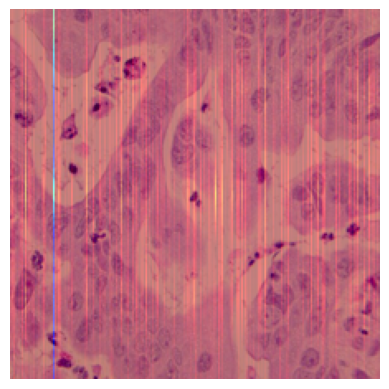

In [11]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import timm

# 1. Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Define the Grad-CAM function
def grad_cam(input_tensor, model, target_layer):
    gradients = []
    activations = []

    def save_gradient(module, grad_input, grad_output):
        nonlocal gradients
        gradients = [grad_output[0]]

    def save_activations(module, input, output):
        nonlocal activations
        activations.append(output)

    # Register hooks
    handle_backward = target_layer.register_full_backward_hook(save_gradient)
    handle_forward = target_layer.register_forward_hook(save_activations)

    # Forward pass
    output = model(input_tensor)

    # Zero gradients
    model.zero_grad()

    # Get the index of the highest scoring class
    class_index = output.argmax(dim=1).item()

    # Backward pass
    output[0, class_index].backward()

    # Remove hooks
    handle_backward.remove()
    handle_forward.remove()

    # Get the gradients and activations
    gradient = gradients[0].cpu().data.numpy()[0]
    activation = activations[0].cpu().data.numpy()[0]

    # Compute the Grad-CAM
    weights = np.mean(gradient, axis=(1, 2))
    cam = np.zeros(activation.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activation[i, :, :]

    cam = np.maximum(cam, 0)  # Apply ReLU
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam) if np.max(cam) != 0 else cam  # Avoid division by zero
    return cam

# 3. Load and preprocess the input image
image_path = '/content/colonca100.jpeg'  # Update this with your image path
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0).to(device)

# 4. Load your model
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
model.eval()

# Get the target layer (the last convolutional layer of the model)
target_layer = model.layers[-1].blocks[-1].norm1  # Update this based on your model architecture

# 5. Generate the Grad-CAM
cam = grad_cam(input_tensor, model, target_layer)

# 6. Display the heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
original_image = np.array(image.resize((224, 224))) / 255  # Load and resize the original image
superimposed_img = heatmap + original_image  # Combine heatmap with original image
superimposed_img = superimposed_img / np.max(superimposed_img)  # Normalize again

# 7. Show the results
plt.imshow(superimposed_img)
plt.axis('off')  # Turn off axis
plt.show()


In [7]:
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms # Import the transforms module

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, class_idx):
        # Get the weights
        weights = F.adaptive_avg_pool2d(self.gradients, 1)
        # Get the class activation map
        # Reshape activations to [batch_size, channels, -1]
        activations = self.activations.view(self.activations.size(0), self.activations.size(1), -1)
        # Perform matrix multiplication to get cam
        cam = torch.matmul(weights.squeeze(3).squeeze(2), activations)
        # Reshape cam to original image dimensions
        cam = cam.view(self.activations.size(0), self.activations.size(2), self.activations.size(3))

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()  # Normalize

        return cam

# Assuming you have loaded your model and input_tensor
# Updated target layer to the last layer's norm1 for swin_base_patch4_window7_224
target_layer = model.layers[3].blocks[-1]  # Adjust according to your preference
grad_cam = GradCAM(model, target_layer)

# Load and preprocess the input image
image_path = '/content/colonca100.jpeg'  # Update this with your image path
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0).to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) # Define input_tensor here

# Forward pass (input_tensor is your input image)
output = model(input_tensor)


# Get the predicted class index
# Assuming you want the class with the highest probability
class_idx = output.argmax(dim=1).item()  # Get predicted class index

# Backward pass
model.zero_grad()
output[0, class_idx].backward()  # class_idx is now defined

# Generate the heatmap
heatmap = grad_cam.generate_cam(class_idx)

# Optionally, you can visualize the heatmap over the original image

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


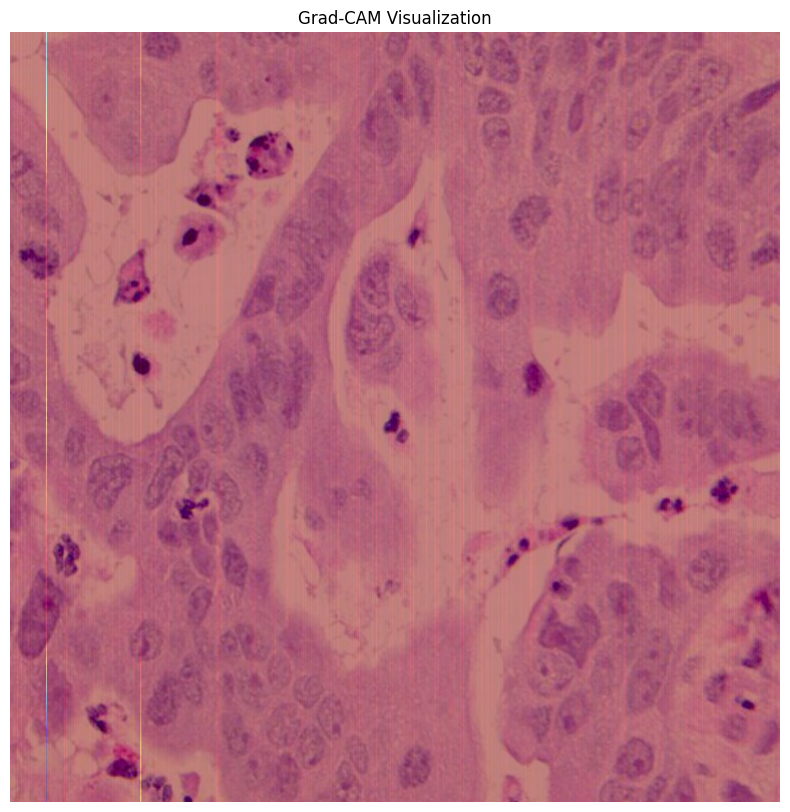

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_grad_cam(original_image, heatmap, alpha=0.5):
    # Resize heatmap to match the original image size
    heatmap = heatmap.detach().cpu().numpy()  # Convert to numpy array

    #Squeeze the heatmap to remove the extra dimension
    heatmap = np.squeeze(heatmap, axis=0) # Remove the first dimension

    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))  # Resize
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap = heatmap / heatmap.max()  # Normalize

    # Apply a colormap (e.g., 'jet' or 'hot')
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    # Load the original image here
    original_image = cv2.imread('/content/colonca100.jpeg') # Assuming this is the path to your image

    # Convert original image to a suitable format (assuming it's in BGR format)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Overlay the heatmap on the original image
    overlayed_image = cv2.addWeighted(original_image, 1 - alpha, heatmap_colored, alpha, 0)

    # Display the result
    plt.figure(figsize=(10, 10))
    plt.imshow(overlayed_image)
    plt.axis('off')  # Hide axis
    plt.title('Grad-CAM Visualization')
    plt.show()

# Assuming 'heatmap' is the output from Grad-CAM
# Call the visualization function, passing the loaded image
# Replace '/content/colonca100.jpeg' with the actual path to your image
original_imag = cv2.imread('/content/colonca100.jpeg')
visualize_grad_cam(original_imag, heatmap)